# CRMS600 Tidal Datums

This notebook inspects and cleans the water level records at CRMS600 gauge so tidal datums can be calculated.

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
%matplotlib notebook

### Import Data

We'll go ahead and import the data as a `pandas.DataFrame`. Note the text encoding is `cp1252` not `UTF8`. Let's go ahead and use the `.head()` method to see the first 5 rows.

In [2]:
df = pd.read_csv('Data/A2AEE5F371E34DEB8F3A1B62D2171061_HYDROGRAPHIC_HOURLY.csv', 
                 encoding='cp1252', low_memory=False)
df.head()

,Station ID,Date (mm/dd/yyyy),Time (hh:mm:ss),Time Zone,Sensor Environment,Raw Water Temperature (°C),Adjusted Water Temperature (°C),Raw Specific Conductance (uS/cm),Adjusted Specific Conductance (uS/cm),Raw Salinity (ppt),...,Raw pH (pH units),Adjusted pH (pH units),Raw Turbidity (FNU),Adjusted Turbidity (FNU),Raw Discharge (cubic ft/sec),Adjusted Discharge (cubic ft/sec),Organization Name,Comments,Latitude,Longitude
0,CRMS0600-H01,7/7/2011,10:00:00,CST,Surface Water,30.04,30.04,13759.3,13759.30,7.89,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Adjusted water elevation to datum and water el...,29.576839,-92.53484
1,CRMS0600-H01,7/7/2011,11:00:00,CST,Surface Water,30.55,30.55,15715.3,15719.77,9.11,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Adjusted water elevation to datum and water el...,29.576839,-92.53484
2,CRMS0600-H01,7/7/2011,12:00:00,CST,Surface Water,30.67,30.67,18249.6,18259.98,10.71,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Adjusted water elevation to datum and water el...,29.576839,-92.53484
3,CRMS0600-H01,7/7/2011,13:00:00,CST,Surface Water,30.31,30.31,21500.1,21518.45,12.81,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Adjusted water elevation to datum and water el...,29.576839,-92.53484
4,CRMS0600-H01,7/7/2011,14:00:00,CST,Surface Water,30.55,30.55,22910.9,22936.97,13.73,...,NaN,NaN,NaN,NaN,NaN,NaN,COASTAL ESTUARY SERVICES LLC,Adjusted water elevation to datum and water el...,29.576839,-92.53484


### Take Necessary Columns

Lets see what columns the data has. It looks like the columns we need are 
`Station ID`, `Date (mm/dd/yyyy)`, `Time (hh:mm:ss)`, `Time Zone`, `Adjusted Water Elevation to Datum (ft)`, `Geoid`,`Latitude`, and `Longitude`.

In [3]:
df.columns

Index(['Station ID', 'Date (mm/dd/yyyy)', 'Time (hh:mm:ss)', 'Time Zone',
       'Sensor Environment', 'Raw Water Temperature (°C)',
       'Adjusted Water Temperature (°C)', 'Raw Specific Conductance (uS/cm)',
       'Adjusted Specific Conductance (uS/cm)', 'Raw Salinity (ppt)',
       'Adjusted Salinity (ppt)', 'Raw Water Level (ft)',
       'Adjusted Water Level (ft)', 'Raw Water Elevation to Marsh (ft)',
       'Adjusted Water Elevation to Marsh (ft)',
       'Raw Water Elevation to Datum (ft)',
       'Adjusted Water Elevation to Datum (ft)',
       'Raw Marsh Mat Elevation (ft)',
       'Adjusted Marsh Mat Elevation to Datum (ft)', 'Geoid',
       'Raw Battery (V)', 'Adjusted Battery (V)', 'Raw Wind Speed (mph)',
       'Adjusted Wind Speed (mph)', 'Raw Wind Direction (degrees)',
       'Adjusted Wind Direction (degrees)', 'Raw Velocity (ft/sec)',
       'Adjusted Velocity (ft/sec)', 'Raw Precipitation (tips/hour)',
       'Adjusted Precipitation (inches)', 'Raw Air Pressure (mm 



Let's go ahead and take a slice of the dataframe on the necessary columns.

In [4]:
df = df[['Station ID', 'Date (mm/dd/yyyy)', 'Time (hh:mm:ss)', 
         'Time Zone','Adjusted Water Elevation to Datum (ft)',
         'Geoid','Latitude','Longitude']]

df.head()

,Station ID,Date (mm/dd/yyyy),Time (hh:mm:ss),Time Zone,Adjusted Water Elevation to Datum (ft),Geoid,Latitude,Longitude
0,CRMS0600-H01,7/7/2011,10:00:00,CST,1.62,GEOID99,29.576839,-92.53484
1,CRMS0600-H01,7/7/2011,11:00:00,CST,1.14,GEOID99,29.576839,-92.53484
2,CRMS0600-H01,7/7/2011,12:00:00,CST,0.81,GEOID99,29.576839,-92.53484
3,CRMS0600-H01,7/7/2011,13:00:00,CST,0.59,GEOID99,29.576839,-92.53484
4,CRMS0600-H01,7/7/2011,14:00:00,CST,0.67,GEOID99,29.576839,-92.53484


Now let's go ahead and use the `describe()` method on the data so we can see some stats on it.

In [5]:
df[['Adjusted Water Elevation to Datum (ft)']].describe()

,Adjusted Water Elevation to Datum (ft)
count,80319.000000
mean,0.997292
std,0.811112
min,-1.670000
25%,0.460000
50%,1.020000
75%,1.560000
max,10.840000


### Check Unique Stations

Let's make sure the data is for one `Station ID` only. We'll use the `.value_counts()` method on the `Station ID` column. Looks like all records belong to `CRMS0600-H01`.

In [6]:
assert len(df['Station ID'].value_counts()) == 1

### Check GEOID's

Let's go ahead and see what GEOIDs the water level data is in. GEOIDs are very important in Louisiana. We can see the data is in `GEOID12A` and `GEOID99`. We want everything in `GEOID12B`. In Louisiana, `GEOID12A` and `12B` are the same. So we'll have to convert the `GEOID99` records to `GEOID12A/B`. 

In [7]:
df['Geoid'].value_counts()

GEOID12A    61690
GEOID99     19598
Name: Geoid, dtype: int64

We'll need the `Latitude` and `Longitude` of the station to use the online `VDATUM` tool from NOAA. Let's make sure the `Latitude-Longitude` pairs are unique.

In [8]:
assert len(df['Latitude'].value_counts())==1
assert len(df['Longitude'].value_counts()) == 1

### Gauge Location Map   

Now let's plot the the gauge location on a map. We'll use the `Folium` package to produce the map.

In [9]:
gage_loc = [df['Latitude'].iloc[0], df['Longitude'].iloc[0]]

m = folium.Map(location=gage_loc, zoom_start=13)

tooltip= 'CRMS600'

folium.Marker(gage_loc, popup=f'<i>{gage_loc}</i>', tooltip=tooltip).add_to(m)

m

### GEOID Conversion

Now let's use the `VDATUM` API from NOAA to convert the `GEOID99` records to `GEOID12A/B`. We'll pass a point with elevation of `0.0 ft` in `GEOID99` and we'll ask for the elevation in `GEOID12B`. 

Note the NOAA API use `s` to denote `source`, and `t` to denote `target`.

The shift is returned as `'tar_height'` below.

In [10]:
import requests
url = 'https://vdatum.noaa.gov/vdatumweb/api/tidal'
response = requests.get(url, params={'lat':gage_loc[0], 'lon':gage_loc[1],
                                    's_v_geoid':'geoid99', 's_v_unit':'us_ft',
                                    't_v_geoid':'geoid12b', 't_v_unit':'us_ft',
                                    't_v_frame':'NAVD88'})

response = response.json()

response

{'region': 'CONTIGUOUS',
 'src_horizontal_frame': 'NAD83_2011',
 'src_vertical_frame': 'NAVD88',
 'src_vertical_unit': 'us_ft',
 'src_vertical_geoid': 'geoid99',
 'src_lon': '-92.5348395',
 'src_lat': '29.57683854',
 'src_height': '0.0',
 'tar_horizontal_frame': 'NAD83_2011',
 'tar_vertical_frame': 'NAVD88',
 'tar_vertical_unit': 'us_ft',
 'tar_vertical_geoid': 'geoid12b',
 'tar_lon': '-92.5348395',
 'tar_lat': '29.5768385',
 'tar_height': '-0.313'}

In [11]:
geoid_shift = float(response['tar_height'])
print(geoid_shift)

-0.313


Now let's go ahead and convert the records that are in `GEOID99` to `GEOID12B`.

In [12]:
for i in df.index:
    if df.loc[i,'Geoid'] == 'GEOID99':
        df.loc[i,'Geoid'] = 'GEOID12B'
        df.loc[i, 'Adjusted Water Elevation to Datum (ft)'] += geoid_shift
        
df.head()

,Station ID,Date (mm/dd/yyyy),Time (hh:mm:ss),Time Zone,Adjusted Water Elevation to Datum (ft),Geoid,Latitude,Longitude
0,CRMS0600-H01,7/7/2011,10:00:00,CST,1.307,GEOID12B,29.576839,-92.53484
1,CRMS0600-H01,7/7/2011,11:00:00,CST,0.827,GEOID12B,29.576839,-92.53484
2,CRMS0600-H01,7/7/2011,12:00:00,CST,0.497,GEOID12B,29.576839,-92.53484
3,CRMS0600-H01,7/7/2011,13:00:00,CST,0.277,GEOID12B,29.576839,-92.53484
4,CRMS0600-H01,7/7/2011,14:00:00,CST,0.357,GEOID12B,29.576839,-92.53484


### Convert to DateTime Object

Until now, all the date and time data are interpreted as strings. We'll go ahead and convert them into `Numpy.Datetime64` objects. 

In [13]:
df['Datetime'] = pd.to_datetime(df['Date (mm/dd/yyyy)'] + ' ' + df['Time (hh:mm:ss)'])

### Convert Time Zone to GMT

Now let's go ahead and convert the Time Zone to `GMT`. In oder to get from `CST` to `GMT`, we'll need to add 6 hours to the time

In [14]:
if (df['Time Zone']=='CST').all():
    df['Datetime'] += pd.Timedelta(value=6, unit='hour')
    df['Time Zone'] = 'GMT'

    
df = df[['Datetime','Time Zone','Adjusted Water Elevation to Datum (ft)']]    
df.head()

,Datetime,Time Zone,Adjusted Water Elevation to Datum (ft)
0,2011-07-07 16:00:00,GMT,1.307
1,2011-07-07 17:00:00,GMT,0.827
2,2011-07-07 18:00:00,GMT,0.497
3,2011-07-07 19:00:00,GMT,0.277
4,2011-07-07 20:00:00,GMT,0.357


### Check for Missing Values

Let's plot the data to see if there are large gaps of missing data. Based on the Plot below, a large data gap appears in mid 2013. We'll start our analysis on `2014-01-01` and we'll look at smaller gaps in the data.

<IPython.core.display.Javascript object>


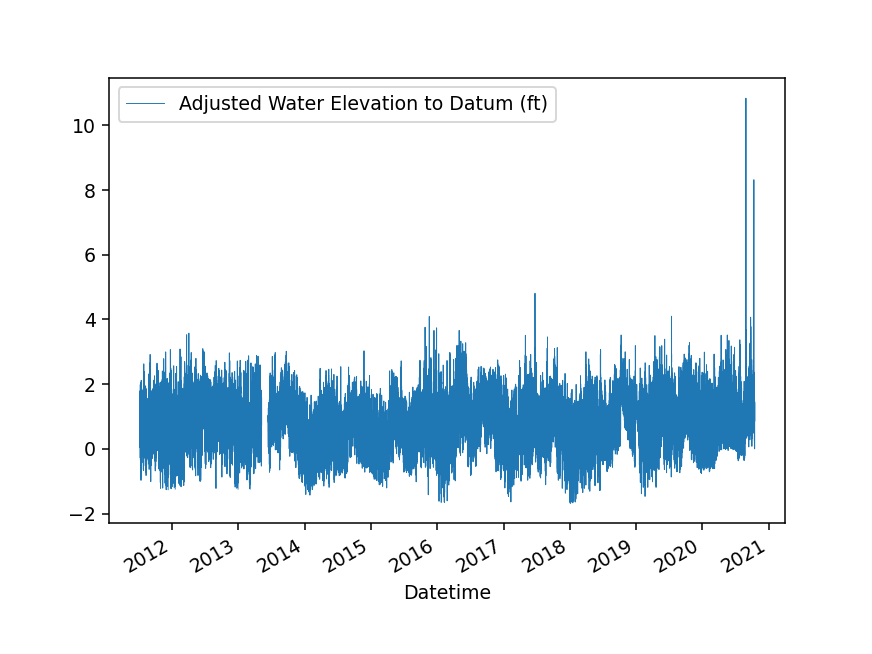

In [15]:
df.plot(x='Datetime', y='Adjusted Water Elevation to Datum (ft)', lw=0.5)

In [16]:
crms_df = df[df['Datetime']>='2014'].copy()
crms_df.head()

,Datetime,Time Zone,Adjusted Water Elevation to Datum (ft)
21800,2014-01-01 00:00:00,GMT,0.70
21801,2014-01-01 01:00:00,GMT,0.63
21802,2014-01-01 02:00:00,GMT,0.86
21803,2014-01-01 03:00:00,GMT,0.64
21804,2014-01-01 04:00:00,GMT,0.66


Now let's check the sliced data and see if there are big gaps in our records. Usually if there are not too many gaps and the gaps are less than 7 hours, we can linearly interpolate these values. Otherwise, we'll need to use other methods such as Fourier Transform or use nearby gauges to fill in the missing data.

The code below uses the `.isna()` method and lists the number of missing instances per calendar day. Looks like the longest gap is 6 hours.

In [17]:
crms_df[(crms_df['Adjusted Water Elevation to Datum (ft)'].isna())]\
        .loc[:,'Datetime'].apply(lambda x:x.strftime('%Y-%m-%d')).value_counts()

2017-04-15    6
2018-01-17    6
2016-02-09    5
2016-01-22    4
2018-02-02    3
2016-02-10    3
2016-01-23    3
2018-01-30    3
2018-01-02    2
2018-01-01    2
2017-04-13    2
2016-02-24    2
2015-06-24    1
2017-04-28    1
2017-04-05    1
2015-01-05    1
2018-07-17    1
2016-10-27    1
2017-04-16    1
2018-01-03    1
2014-04-24    1
2018-06-01    1
2017-04-20    1
2017-04-04    1
2015-10-13    1
2017-08-10    1
2015-02-13    1
2017-03-30    1
2017-04-11    1
2017-03-29    1
2017-05-05    1
Name: Datetime, dtype: int64

### Interpolate Missing Values

We'll now use the `.interpolate()` method in `Pandas` to interpolate `NaN` values.

In [18]:
crms_df['Water Level Interpolate (ft)'] = crms_df[['Adjusted Water Elevation to Datum (ft)']]\
                                            .interpolate(method='linear', limit=7)


In [19]:
assert crms_df['Water Level Interpolate (ft)'].isna().sum()==0

### Convert to COOPS Datum Calculator Format

We'll now convert the format of the data to COOPS Datum Calculator format. First column should be date in `mm/dd/yyyy HH:mm` format and second column should be water level.

In [20]:
crms_df=crms_df[['Datetime','Water Level Interpolate (ft)']]
crms_df['Col1'] = crms_df['Datetime'].apply(lambda x:x.strftime('%m/%d/%Y %H:%M'))
crms_df['Col2'] =  crms_df['Water Level Interpolate (ft)']
crms_df = crms_df[crms_df['Datetime']<'2020-10-01']
crms_df.tail()

,Datetime,Water Level Interpolate (ft),Col1,Col2
80955,2020-09-30 19:00:00,1.77,09/30/2020 19:00,1.77
80956,2020-09-30 20:00:00,1.85,09/30/2020 20:00,1.85
80957,2020-09-30 21:00:00,1.74,09/30/2020 21:00,1.74
80958,2020-09-30 22:00:00,1.28,09/30/2020 22:00,1.28
80959,2020-09-30 23:00:00,1.08,09/30/2020 23:00,1.08


In [21]:
crms_df.to_csv('CRMS600_Coops_Format.csv',index=False, columns=['Col1', 'Col2'], 
               header=False, float_format="%.3f")

### CRMS600 Tidal Datums

The table below contains the tidal datums calculated for the CRMS600 Station.

<img src="./Results/CRMS600_Datums.png?3">

### Sensitivity Analysis

We'll now do some sensitivity analysis looking at various epoch lengths and the standard deviation in calculated tidal datums. We know the starndard epoch for calculating tidal datums is 19 years. We want to use the shortest epoch possible while meeting our standard deviation threshold. Our goal is to achieve a standard deviation `0.1 ft` or below. Let's start by loading the `High-Lows.csv` from the Datum calculator output. We see the `L`, `LL`, `H`, and `HH` values are listed for the period of our data.

In [22]:
import zipfile

zip_file = zipfile.ZipFile('Results/CRMS600Result.zip')
file = zip_file.read('High-Lows.csv').decode()
file = file.splitlines()
file = [line.split(',') for line in file]

crms_hl = pd.DataFrame(file, columns=['DateTime', 'value', 'desc'])
crms_hl['value'] = crms_hl['value'].astype('float32')
crms_hl['desc'] = crms_hl['desc'].apply(lambda x:x.strip())

crms_hl['DateTime'] = pd.to_datetime(crms_hl['DateTime'])

crms_hl.head()

,DateTime,value,desc
0,2014-01-01 01:00:00,0.630000,L
1,2014-01-01 07:00:00,1.338254,H
2,2014-01-01 14:00:00,-0.895556,LL
3,2014-01-01 22:00:00,1.735556,HH
4,2014-01-02 04:00:00,1.050952,L


#### Datum Calculator Function

Let's define a function to calculate the tidal datums using the `L`, `LL`, `H`, and `HH` values.

`MHHW` is the arithmatic mean of all the `HH` values.

`MHW` is the arithmatic mean of all the `HH` and `H` values.

`MSL` is the arithmatic mean of all the `L`, `LL`, `H`, and `HH` values.

`MLW` is the arithmatic mean of all the `L`, and `LL` values.

`MLLW` is the arithmatic mean of all the `LL` values.

In [23]:
def get_datums(df):
    MHHW = df[df['desc']=='HH'].mean().value
    MHW = df[(df['desc']=='HH')|(df['desc']=='H')].mean().value
    MSL = df.mean().value
    MLW = df[(df['desc']=='LL')|(df['desc']=='L')].mean().value
    MLLW = df[(df['desc']=='LL')].mean().value
    start = df['DateTime'].min().normalize()
    end = df['DateTime'].max().normalize()
    return pd.DataFrame(columns=['MHHW', 'MHW', 'MSL', 'MLW', 'MLLW', 'start', 'end'],
                       data = [[MHHW, MHW, MSL, MLW, MLLW, start, end]])

Now let's test our function to see if we are getting the same values as the Datum Calculator. As expected, we are computing very similar values.

In [24]:
get_datums(crms_hl)

,MHHW,MHW,MSL,MLW,MLLW,start,end
0,1.696549,1.509594,0.91179,0.313985,-0.098832,2014-01-01,2020-09-30


#### Calculate Datum over an Interval

Let's define a function that calculates the tidal datums over an interval and store the `start date`, `end_date`, `MHHW`, `MHW`, `MSL`, `MLW`, and `MLLW` in a dataframe.

In [25]:
#interval in months
def get_datums_over_interval(df, interval=1):
    months = df['DateTime'].apply(lambda x:x.to_period('M')).unique()
    ans = pd.DataFrame(columns=['start', 'end', 'MLLW', 'MLW', 'MSL', 'MHW', 'MHHW'])

    for month in months:
        start = month
        end = start + (interval-1)
        if end not in months:
            break
        start = start.to_timestamp(how='start')
        end = end.to_timestamp(how='finish')
        temp = df[(df['DateTime']>=start)&(df['DateTime']<=end)]
        ans=ans.append(get_datums(temp))
    return ans

Let's test our function and see if we get the same data as the Datum calculatro. It appears that we are computing very similar values compared to the online Datum calculator.

In [36]:
months = crms_hl['DateTime'].apply(lambda x:x.to_period('M')).unique()
get_datums_over_interval(crms_hl, interval=len(months))

,start,end,MLLW,MLW,MSL,MHW,MHHW
0,2014-01-01,2020-09-30,-0.098832,0.313985,0.91179,1.509594,1.696549


Now let's go ahead and do a sensitivity analysis on the `MHW` stats by epoch length. It appears that a 24 month epoch provides a standard deviation of 0.11 ft.

In [28]:
temp = []
for epoch in range(1, 37):
    highest = get_datums_over_interval(crms_hl, interval=epoch).describe().loc['max','MHW']
    lowest = get_datums_over_interval(crms_hl, interval=epoch).describe().loc['min','MHW']
    std = get_datums_over_interval(crms_hl, interval=epoch).describe().loc['std','MHW']
    temp.append([epoch, highest, lowest, std])
    
crms_sens = pd.DataFrame(temp, columns=['epoch length (months)', 'highest', 'lowest', 'std'])
crms_sens

,epoch,highest,lowest,std
0,1,2.358455,0.766365,0.374213
1,2,2.297713,0.843418,0.329934
2,3,2.149199,0.857146,0.294586
3,4,1.986911,0.951955,0.265114
4,5,1.969743,1.010900,0.242781
5,6,1.978651,1.060798,0.228407
6,7,1.941901,1.091605,0.217577
7,8,1.904770,1.108468,0.208281
8,9,1.853888,1.141464,0.200290
9,10,1.823034,1.157913,0.193024


Now let's go ahead and plot the `MHW` range and its `Standard Deviation` vs epoch length. 

<IPython.core.display.Javascript object>


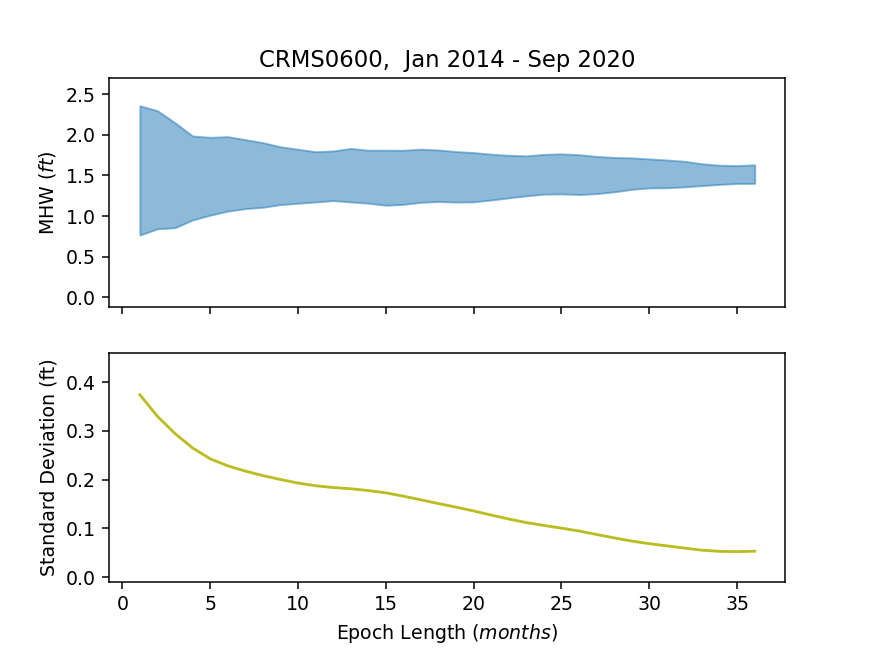

In [41]:
fig, (top, bot) = plt.subplots(2,1, sharex=True)


top.fill_between(crms_sens['epoch'], crms_sens['highest'], crms_sens['lowest'], alpha=.5, color='tab:blue')
top.set_ylim(-0.12,2.7)
top.set_ylabel('MHW ($ft$)')
bot.plot(crms_sens['epoch'],crms_sens['std'], c='tab:olive')
bot.set_ylim(-0.01,0.46)
bot.set_ylabel('Standard Deviation (ft)')
bot.set_xlabel('Epoch Length ($months$)')
top.set_title('CRMS0600,  Jan 2014 - Sep 2020');

It appears that a 24 month epoch fits our purpose. The chart below plots the calculated`MHW` over a 24-month epoch vs the epoch start date. We can see an upward trend.

<IPython.core.display.Javascript object>


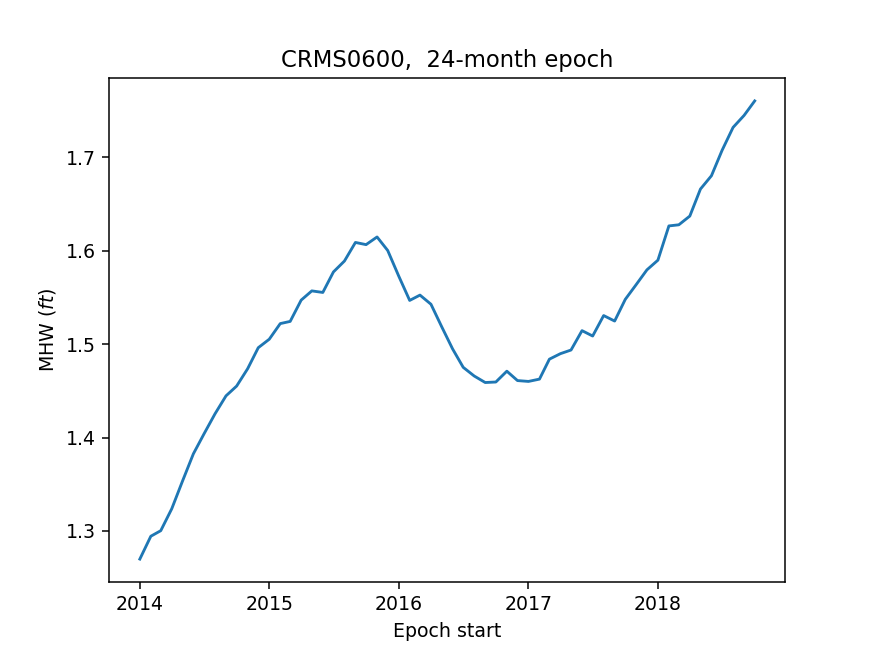

In [42]:
temp = get_datums_over_interval(crms_hl,interval=24)
plt.figure()
plt.plot(temp['start'],temp['MHW'])
plt.ylabel('MHW ($ft$)')
plt.xlabel('Epoch start')
plt.title('CRMS0600,  24-month epoch');

#### Conclusion

We want our calculated datums to reflect the most recent water levels. Therefore let's go ahead and calculate the datums over the last 24-months of the data.

In [44]:
get_datums_over_interval(crms_hl,interval=24).tail(1)

,start,end,MLLW,MLW,MSL,MHW,MHHW
0,2018-10-01,2020-09-30,0.107883,0.509417,1.135102,1.760269,1.96786


In [32]:
# url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
# response =requests.get(url, params={'station':8766072,'product':'hourly_height',
#                                     'begin_date':20200101,'end_date':20200131,
#                                     'units':'english', 'datum':'NAVD', 'time_zone':'GMT',
#                                     'format':'JSON'})

# noaa_df = pd.DataFrame(response.json()['data'])
# noaa_df.rename(columns={'t':'Datetime', 'v':'Water Level(ft)'},inplace=True)
# noaa_df['Datetime'] = pd.to_datetime(noaa_df['Datetime'])

# noaa_df['Water Level(ft)'] = noaa_df['Water Level(ft)'].astype('float32')

# noaa_df.head()

In [33]:
# import matplotlib.dates as mdates

# locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
# formatter = mdates.ConciseDateFormatter(locator)


# crms_df = df[(df['Datetime']>='2020-01-01')&(df['Datetime']<='2020-01-31')]

# plt.figure()

# plt.plot(noaa_df['Datetime'], noaa_df['Water Level(ft)'])
# plt.plot(crms_df['Datetime'], crms_df['Adjusted Water Elevation to Datum (ft)'], c='tab:red')

# ax = plt.gca()
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)
